Importación de datos

In [1]:
import kagglehub
import shutil
import os

# Descargar dataset
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

# Obtener el directorio de trabajo actual
destination_path = os.getcwd()+'/dataset/'
if not os.path.exists(destination_path):
    # Copia la carpeta de forma recursiva
    shutil.copytree(path, destination_path)

c:\Program Files\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargar imágenes y etiquetas

In [ ]:
import cv2
import os
from tqdm import tqdm

# Inicializamos las listas para las imágenes y las etiquetas
X = []  # Imágenes
y = []  # Etiquetas

# Carpeta del dataset
datasetPath = 'dataset/lung_colon_image_set/'

# Definir las subcarpetas de las clases 
dirs = [
    datasetPath + 'colon_image_sets/colon_aca',
    datasetPath + 'colon_image_sets/colon_n',
    datasetPath + 'lung_image_sets/lung_aca',
    datasetPath + 'lung_image_sets/lung_n',
    datasetPath + 'lung_image_sets/lung_scc'
    ]

labels = [0, 1, 2, 3, 4]

# Procesar cada clase
for dir, label in zip(dirs, labels):
    # Verificar si el directorio existe
    if not os.path.exists(dir):
        print(f"Directorio no encontrado: {dir}")
        continue  # Saltar si no existe el directorio

    # Listar las imágenes en la subcarpeta de la clase
    files = os.listdir(dir)

    for file in tqdm(files, desc=f"Procesando {dir}"):
        filePath = os.path.join(dir, file)  # Forma segura de concatenar rutas
        # Cargar la imagen
        image = cv2.imread(filePath)

        if image is not None:  # Asegurarse de que la imagen se cargó correctamente
            # Añadir la imagen a X y la etiqueta a y
            X.append(image)
            y.append(label)
        else:
            print(f"Error al cargar la imagen: {filePath}")


Procesando dataset/lung_colon_image_set/colon_image_sets/colon_aca: 100%|██████████| 5000/5000 [00:15<00:00, 324.17it/s]
Procesando dataset/lung_colon_image_set/colon_image_sets/colon_n: 100%|██████████| 5000/5000 [00:14<00:00, 333.64it/s]
Procesando dataset/lung_colon_image_set/lung_image_sets/lung_aca: 100%|██████████| 5000/5000 [00:11<00:00, 443.22it/s]
Procesando dataset/lung_colon_image_set/lung_image_sets/lung_n: 100%|██████████| 5000/5000 [00:31<00:00, 160.91it/s]
Procesando dataset/lung_colon_image_set/lung_image_sets/lung_scc: 100%|██████████| 5000/5000 [00:42<00:00, 117.32it/s]


Preparación de los datos

In [ ]:
import numpy as np
import keras

# Normalizar las imágenes
X = np.array(X) / 255.0

# Convertir las listas a arrays numpy
y = np.array(y)

# Convertir datos de y a matrices binarias
y=keras.utils.to_categorical(y,len(labels))

In [ ]:
from sklearn.model_selection import train_test_split
print(X.shape)
print(y.shape)

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
# Mostrar las dimensiones de los datos
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

(25000, 64, 64, 3)
(25000, 5, 5)


ValueError: Found array with dim 3. None expected <= 2.

Visualizar las imágenes

In [ ]:
import matplotlib.pyplot as plt

def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

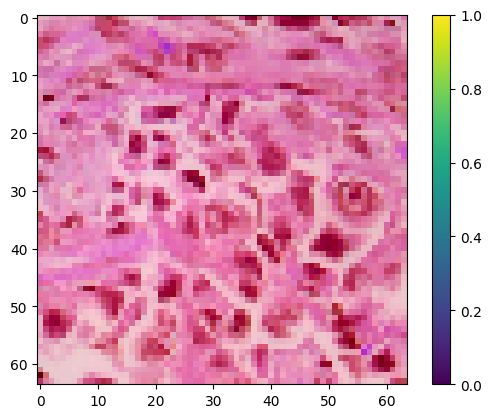

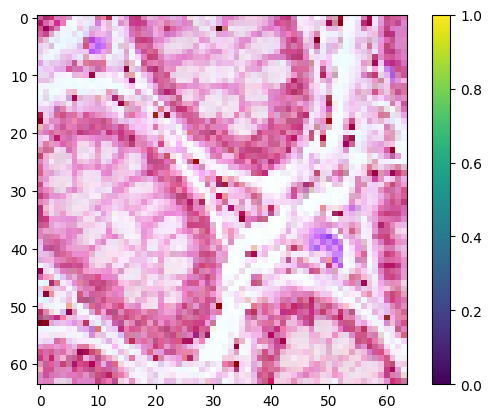

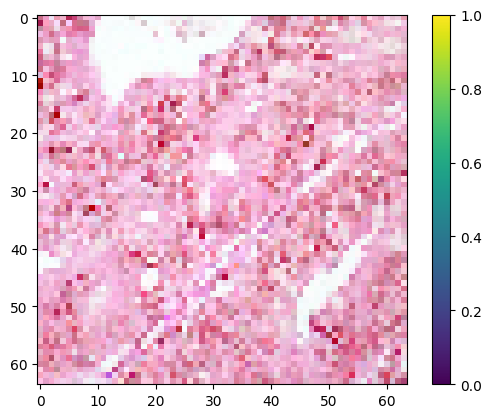

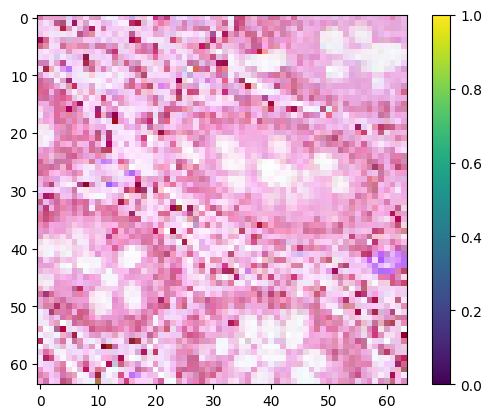

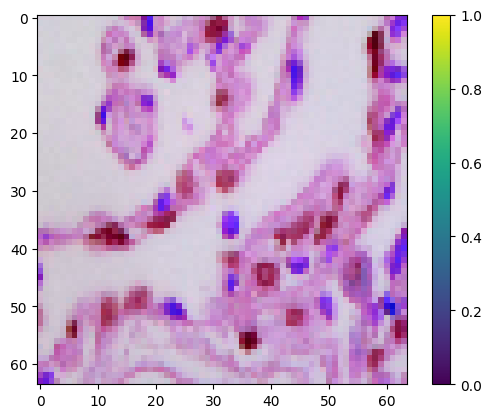

In [ ]:
for i, x in enumerate(X_test[:5]):
  visualize_example(x)

In [ ]:
num_classes = 5

## Modelo de Javi

In [ ]:
from keras.regularizers import l2
filters = 32  # Valor de ejemplo para filtros
kernel_size = (3, 3)  # Valor de ejemplo para el tamaño del kernel

conv_layer = keras.layers.Conv2D(
    filters, 
    kernel_size, 
    strides=(1, 1), 
    padding='valid', 
    data_format=None, 
    dilation_rate=(1, 1), 
    activation=None, 
    use_bias=True, 
    kernel_initializer='glorot_uniform', 
    bias_initializer='zeros', 
    kernel_regularizer=None, 
    bias_regularizer=None, 
    activity_regularizer=None, 
    kernel_constraint=None, 
    bias_constraint=None    
)
# Construcción del modelo secuencial
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last", activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.01)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')
])

# Resumen del modelo
model.summary()

# Compilación del modelo
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Javier\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 58, 58, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 430592)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │   110,231,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,326,598 (420.86 MB)

 Trainable params: 110,326,598 (420.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense



# Aseguramos que y_train y y_val están codificados en one-hot
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
print(X_train.shape, y_train.shape)
# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    validation_data=(X_val, y_val),
    batch_size=32,  # Especificar el tamaño del batch (opcional)
    verbose=1       # Ajustar el nivel de verbosidad (opcional)
)


(16000, 64, 64, 3) (16000, 5, 5, 5, 5)
Epoch 1/15


ValueError: Sequential model 'sequential_3' has already been configured to use input shape (None, 64, 64, 3). You cannot build it with input_shape (32, 64, 64, 3)

## Modelo David

In [ ]:
# Cargamos un modelo pre-entrenado con Imagenet
vgg_model = VGG19(include_top=False, weights="imagenet", input_shape=input_shape)

# Congelamos al modelo / que los parámetros no se actualicen
for layer in vgg_model.layers[:12]:
  layer.trainable = False

In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(units=500, activation="relu"))
model.add(Dense(units=num_classes,   activation="softmax"))
model.compile(optimizer='sgd', # Mejor optimizador
              loss="categorical_crossentropy",
              metrics=["acc"])
history=model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2)

In [ ]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  epochs_range = np.arange(1, len(history.history['acc']) + 1)
  plt.plot(epochs_range,history.history['acc'])
  plt.plot(epochs_range,history.history['val_acc'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  epochs_range = np.arange(1, len(history.history['acc']) + 1)
  plt.plot(epochs_range,history.history['loss'])
  plt.plot(epochs_range,history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

In [ ]:
plot_acc(history)

In [ ]:
plot_loss(history)

## Modelo Erik

In [ ]:
# Crear un modelo simple de CNN para clasificación de imágenes
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Número de clases (6)
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Extraer métricas del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Número de épocas
epochs = range(1, len(train_loss) + 1)

# Crear las gráficas
plt.figure(figsize=(12, 5))

# Gráfica de pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Gráfica de exactitud (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
